# Task 3: Simulation of a GBS experiment

- Here we read params from input file.

In [2]:
import os

import numpy as np
from plotly import offline
from strawberryfields.apps import vibronic, sample, plot
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
inputfile = open("Task2Code/V3-normal-mode-constraint.gbs.in", "r")

N=int(inputfile.readline())     #Number of Atoms
nmodes=3*N-6                    #Number of Modes

w=np.zeros(nmodes,float)        #vib. frequencies of ground electronic state
wp=np.zeros(nmodes,float)       #vib. frequencies of excited electronic state
Ud=np.zeros((nmodes,nmodes),float)   #Duschinsky Matrix
delta=np.zeros(nmodes,float)    #Displacement Vector

T = 500  # temperature

for i in range(nmodes):
    line = inputfile.readline()
    w[i]=float(line)

for i in range(nmodes):
    line = inputfile.readline()
    wp[i]=float(line)
for i in range(nmodes):
    for j in range(nmodes):
        line = inputfile.readline()
        Ud[i,j]=float(line)

for i in range(nmodes):
    line = inputfile.readline()
    delta[i]=float(line)

t, U1, r, U2, alpha = vibronic.gbs_params(w, wp, Ud, delta, T)

for nr_samples in [10, 100, 1000, 10000, 20000]:
    s = sample.vibronic(t, U1, r, U2, alpha, nr_samples)

    e = vibronic.energies(s, w, wp)
    spectrum = plot.spectrum(e, xmin=-300, xmax=2000)
    offline.plot(spectrum, filename=f"spectrum-{nr_samples}.html")
    np.save(f'V3-e-{nr_samples}.npy', e)
    np.save(f'V3-s-{nr_samples}.npy', s)


- Then draw Lorentzian fitting of each spectrum
- 1000 samples seems to be sufficient for fitting

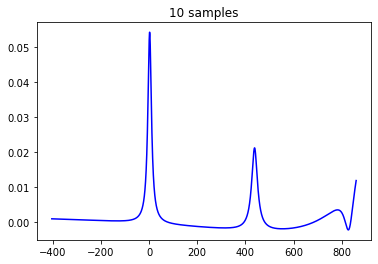

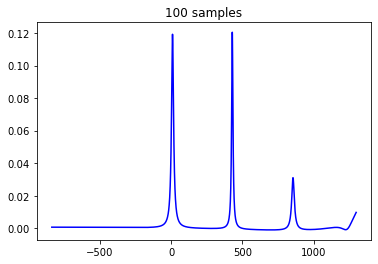

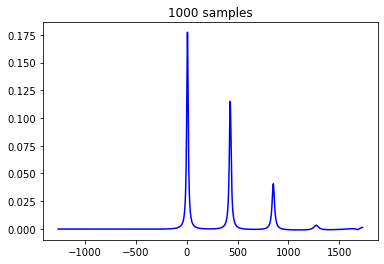

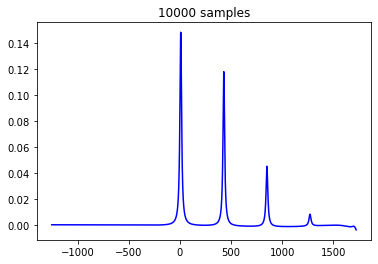

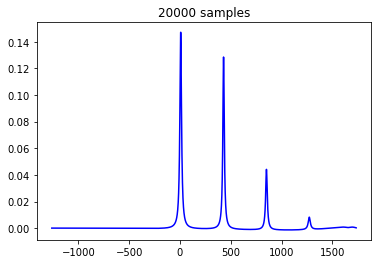

In [8]:
from lorentzian_smoothing import smooth
import matplotlib.pyplot as plt
bins_count = 3000
tol = 1e-3
for nr_samples in [10, 100, 1000, 10000,  20000]:
    e = np.load(f'V3-e-{nr_samples}.npy')
    e_hist, bins = np.histogram(e, bins=bins_count)
    e_hist_smooth = smooth(xData=bins, yData=e_hist, width=20, max_peaks=10, ftol=tol, xtol=tol, gtol=tol, initial_guess_x=0, x0_step=420)
    fig = plt.figure()
    plt.plot(bins, e_hist_smooth, color='b')
    # plt.plot(bins_shifted[:-1], e_hist/max(e_hist), color='r')
    plt.title(f'{nr_samples} samples')
    plt.show()
    np.save(f'e-{nr_samples}-smooth.npy', e_hist_smooth)

- Comparison of Task2 result

- Seems fitting good

/Users/shukob/opt/anaconda3/envs/CohortProject_2020_37/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


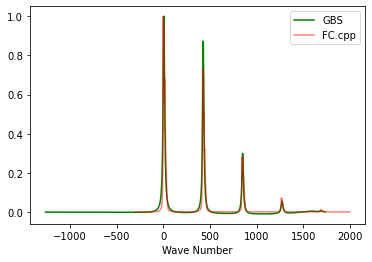

In [24]:
import pandas as pd

spec_df = pd.read_csv('Task2Code/V3-normal-mode-constraint.spec.out', delimiter='  ', header=None)

spec_df.columns = ["Wave Number", "FCF"]
spec_df.set_index('Wave Number')
spec_df.loc[:, 'FCF'] /= spec_df['FCF'].max()
fig = plt.figure()
ax = plt.axes()
ax.plot(bins, e_hist_smooth / max(e_hist_smooth), color='g', label='GBS')
ax.legend()
_ = spec_df.plot(x = 'Wave Number', y='FCF', ax=ax, color='r', alpha=0.5, label='FC.cpp')